GSSR

Gene Splice Site Recognition by WAM, Bayesian Network and SVM approaches

**This is a deprecated notebook, as ipynb has very little support for figure annotations, please check the latex version.**

# Abstract

As molecular biology and information technology advances, splice site recognition and splice signal detection became a key problem in Bioinformatics. In the past three decades, several models have been proposed to solve this problem [1,2,3]. In this work, the Weighted Array Model [1], Bayesian network [2,3], and Support Vector Machine [4,5] have been applied and evaluated on both balanced data and unbalanced data. And edge corrections were made on the Bayesian network to detect splice signals precisely. The result shows that SVM has a good ability on unbalanced data while WAM and BN do not. Besides, the fitness of metrics is also tested. It shows that $auPRC$ [6] is more sensitive to unbalanced data and so is more applicable in many situations.

# Brief Introduction

As molecular biology has an insight into gene regulation and RNA splicing, recognition of RNA splice site became a key problem. In the recent 2 decades, several methods have been proposed to solve the problem. But their ability of take care of unbalanced data have not been tested yet. In this work, a test of WAM, BN, SVM on both balanced data and unbalanced data were produced.

## Splice Site

Splice site [7] , in molecular biology, is a position on RNA where RNA splicing occurs. RNA splicing is a form of RNA processing in which a newly made precursor messenger RNA (pre-mRNA) transcript is transformed into a mature messenger RNA (mRNA). After splicing, introns (Non-coding regions) are removed and exons (Coding Regions) are joined together. 

There are donor sites (5' end) and acceptor sites (3' end) within introns [28].

## Models

As Biology advances, computational methods are now the only realistic way to answer many questions in modern biology [29]. For the problem of splice site recognition, there are several models have been peoposed.

**Weighted Array Model** [1] is a frequency-based approach. It calculate the frequency of each adjacent bases in specific positions to fill into a weight array matrix, and use weight matrix to score unknown site. It has the ability to detect some signals like common bases amoung donors. The limitation of this approach, in a machine learning perspective, is its poor ability to automatically calculate hidden features, like GC content. There might be much more complex features that contribute to splice signal transduction. 

**Bayesian Network** [2,3] is a Bayesian method. It learns DAG structure and conditional probabilities distribution from the data. It has the ability to take care of dependence between positions. It also has the ability to imputate the missing value of the data. and besides, it can work like a Bayesian classifier when there is conditional probability from features to label of each sample. The limitation of this approach, is its unprecise and ineffective structure learning algorithm. PC-Constraints based learning algorithm forms loops in DAG and causes errors sometimes. MMHC algorithm is too slow when there is hundreds or thousands of nodes. Structrual expectation maximization is quite good, but still needs prior expert knowledges.

**Support Vector Machine** [4,5] is a mature supervised learning method. It employs support vectors to maximize the margin and kernel trick to classify linearly indivisible data. This allows for significant savings in calculations. But detecting signals via SVM is not a good choice, because over three-dimensional hyper-plane within SVM cannot be visualized and analyzed. This is the flaw of SVM in data mining, it has the ability to classify but is almost useless for human interpretation of results.

# Material and Method

## Environment

In [167]:
import pickle
import warnings
import importlib
import import_ipynb
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib.image as pli
from Models import WAM, BN, SVM
from Evaluator import Evaluator
from matplotlib import pyplot as plt
from Utils import load_data, Summary, Validation_Sum, no_box
from IPython.display import display, Markdown, Latex, HTML
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from pgmpy.estimators import MmhcEstimator, ConstraintBasedEstimator

plt.ion()
plt.style.use(['science','ieee','no-latex'])
warnings.filterwarnings("ignore")

## Data sets

To comprehensively compare their performances, two data sets were used as data are usually unbalanced in Biology. Models may perform differently in that way. The first data set, which is balanced, was used to training and testing models' performance in a general way. And the second dataset is an unbalanced data set, was used to training and thus testing their performance like real conditions. Because unbalanced data is common in Biology and even many other fields.

The basic information of the two data sets is as follows.

In [135]:
training_set, testing_set = load_data()
training_set1 = training_set[0:5000]
testing_set1 = testing_set[0:5000]
training_set2 = training_set[1500:6500].reset_index(drop=True)
testing_set2 = testing_set[1500:6500].reset_index(drop=True)

Summary(training_set1, testing_set1, training_set2, testing_set2)

,nSample,nDonor : nPSeudo,Type
Dataset 1,10000,5278 : 4722,Unbalanced
Dataset 2,10000,2278 : 7722,Balanced


## Feature Extraction and Encoding

To build reliable models and test their performances, high-quanlity data must be extracted. Splice site dataset, which contains $5278$ donor sites and $4722$ pseudo sites, was extracted from original sequence data. And only $10$ bases before and after the site to be tested were extracted.

When encoding sequence features, one-hot encoder [8] was introduced. And considering simplisity of the experiments, samples with $base_{ambiguous} \in \{W,M,S,K,R,Y,B,D,H,V,N,Z\}$ [9] were discarded. Next, a One-hot encoder are used to encode sequence to a numeric feature vector. For instance, sequence $A...T$ was encoded as $[1,0,0,0...0,0,0,1]$.

## Model Implements and Test core

The 3 models are mainly implemented using Python [10]. Besides, the Bayesian network model and Support vector machine was implemented based on Pgmpy and Scikit-learn packages [11,12]. As far as possible, these models have been designed to be practically applicable. They contain several very easy-to-use program interfaces: `fit`, `predict_probas`, `predict_scores` and `predict_classes`. For all 3 models, the `fit` method is used for training, and the other 3 `predict` methods are used for prediction. The `predict_probas` is used for predicting the probabilities each sample belonging to each class, the `predict_scores` are used for calculating the $S(X)$, and the `predict_classes` are used for predicting the class to which each sample belongs, this is done by comparing the $S(X)$ and given threshold $T$. Most importantly, the $S(X)$ is calculated by:
$$S_m(X) = ln(\frac{P_m^+ (X)}{P_m^- {X}}), m\in\{wam, bn, svm\} \tag{1}$$

## Stratagies for WAM to perform recognition

When recoginizing Gene splice site, the 3 steps were mainly used to determine the potential of each sample being a splice site. Firstly, Laplace pseudocount $C_p$ [13] are used to smooth categorical data. Secondly, the weights of positive and negative submodels, which are the frequencies of adjacent base pairs in WAM, are calculated using the following formula.
$$f(x) = \frac{C_{x,p}+C_p}{N},x \in \{aa,ac,ag,...tt\} \tag{2} $$ Where $N$ is the total number of samples. $C_{x,p}$ is the total number of specific adjacent base pairs occurring at position $p-l+1...p$ in all samples. $C_p$ is the pseudocount, and $l$ is the length of array considered, which refers to the range of dependence between adjacent base pairs considered in experiments. And finally, the potential of unknown samples being donor sites were given by
$$S_{wam}(X) = ln(\frac{P^+(X)}{P^-(X)}) = \sum_{x=2}^{L}{ln(\frac{f^+(x)}{f^-(x)})} \tag{3}$$
Where $L$ is the length of input sequence.
Most importantly, $l$ and $C_p$ are set to $2$ and $0.5$ respectively. 

## Stratagies for BN to learn structures and parameters from data

To perform accurate structure and parameter learning for Bayesian Network, Two algorithms were used: PC constraint-based learning algorithm [14] for structure learning and Bayesian estimation for parameters learning. 

The PC algorithm learns the DAG structure in three steps [30]. First, find the graph skeleton and separating sets of removed edgesStep. Second, orient v-structures based on separating sets. Finally, propagate orientations of v-structures to as many remaining undirected edges as possible. The Bayesian estimator then estimates conditional probability distribution for each node in the graph.

## Strategies for BN to detect splice signal

Because of Bayesian inference, Bayesian network can handle the causal relationship between nodes. In this project, Bayesian network have been improved to be able to calculate the splicing donor potential of DNA sequences. In which both two kinds of data are retained: the feature nodes $N_{f}, f\in \{-10,-9,...10\}$ and label node $N_L$. In the Bayesian network, each feature node has $state_f \in \{a,c,g,t\}$ and label node has $state_L\in \{0,1\}$. To enable Bayesian network to learn conditional probability for all nodes $N \in \{N_{-10},N_{-9},...N_{10},N_{L}\}$, both donor sites and pseudo sites are fitted in a Bayesian network. Finally, when predicting new sites, the Bayesian network will treat new sites as sample with missing label. It uses a missing data imputation algorithm to calculate the probability of label in each state, which then gives the donor potential. See [Models.ipynb](https://github.com/AdeBC/GSSR/blob/master/Source/Models.ipynb) for implements and 2.3 test score for donor potential calculation.

## Correction

Since Bayesian networks cannot perfectly infer causality between $N_f$ and $N_L$,  correction to directions of edges was performed. After construting a DAG structure, the edges from $N_L$ to $N_f, f \in \{−10,−9,...10\}$ are reversed (see [Models.ipynb](https://github.com/AdeBC/GSSR/blob/master/Source/Models.ipynb)). For example, the edge $N_L \rightarrow N_{-1}$ are reversed into $N_L \leftarrow N_{-1}$.

## Settings for SVM to classify splice sites

In the experiment, Gaussian Kernel function [15] were used to map vectors to higher-dimensional feature space. The $\gamma$ for Gaussian Kernel are set to $ 1/(Num_{features}Variance_{data})$. All other parameters are default values (Scikit-learn version 0.23.1). See details in [Sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC).
$$\tag{4}K(x_i, x_j) = exp(-\gamma||x_i - x_j||^2), \gamma > 0$$

In [4]:
class Model:
    
    def __init__(self):
        self.wam = WAM()
        self.bn = BN(struc_estr=ConstraintBasedEstimator
                     #struc_estr=MmhcEstimator#, max_ci_vars=5
                    )
        self.svm = SVM(kernel='rbf', gamma='scale', random_state=1, probability=True, verbose=True)
        
model_1 = Model()
model_2 = Model()

## Cross-validation

To test the accuracy of three models, a simple cross-validation [16] was performed. In both two experiments, independent and identically distributed testing set with was selected. 

## Evaluation

To visualize and compare classification results of 3 models, ROC curves [17] and PR curves [18] are plotted using Matplotlib package [26,27]. To realize this, a sample-based evaluation method is introduced:

$$ TP_t = \sum_{i=0}^N I(S_i\geq t \land L_i = 1) \tag{5} $$

$$ FP_t = \sum_{i=0}^N I(S_i\geq t \land L_i = 0) \tag{6}  $$ 

$$ TN_t = \sum_{i=0}^N I(S_i< t \land L_i = 0) \tag{7}  $$ 

$$ FN_t = \sum_{i=0}^N I(S_i< t \land L_i = 1) \tag{8}  $$ 

where $TP_t$, $FP_t$, $TP_t$, $TN_t$ are statistics for models' prediction result in specific threshold $t$. $I(True) = 0$ and $I(False) = 1$, $L_i$ is label for $ith$ sample. $S_i$ is the score calculated based on probability for $ith$ sample. $t\in \{-25, -24.5, -24, ...24.5, 25\}$ is the threshold used in the evaluation. 

And following metrics were used in the evaluation.

$$ TPR_t = \frac{TP_t}{TP_t+FN_t} \tag{9}  $$ 

$$ FPR_t = \frac{FP_t}{FP_t+TN_t} \tag{10}  $$ 

$$ Sn_t = \frac{TP_t}{TP_t+FN_t} \tag{11}  $$ 

$$ Sp_t = \frac{TN_t}{TN_t+FP_t} \tag{12}  $$ 

$$ Pr_t = \frac{TP_t}{TP_t+FP_t} \tag{13}  $$ 

$$ Rc_t = \frac{TP_t}{TP_t+FN_t} \tag{14}  $$ 

$$ F1-score_t = \frac{2Pr_t Rc_t}{Pr_t+Rc_t} \tag{15} $$

Finally, $auROC$ (the area under ROC curve) [19] and $auPRC$ (the area under Precision-Recall curve) [6,18] were calculated using Composite Trapezoidal rule [20]:

$$ auROC = \sum_{i=1}^{N-1} \frac{(FPR_{i+1} - FPR_i)(TPR_i+TPR_{i+1})}{2} \tag{16} $$

$$ auPRC = \sum_{i=1}^{N-1} \frac{(Rc_{i+1} - Rc_i)(Pr_i+Pr_{i+1})}{2} \tag{17} $$

For implements, see [Evaluator.ipynb](https://github.com/AdeBC/GSSR/blob/master/Source/Evaluator.ipynb).

# Result and Discussion

In this section we discuss the result of two experiments and learning result of WAM and BN in the first experiments.

## Model Training

Three models were trained here. WAM and BN were trained and tested using sequence features, and SVM was trained and tested using numerical features. The numerical features were encoded using One-hot (see 2.3 feature extraction).

In [5]:
model_1.wam.fit(training_set1['Seq. features'], training_set1['IsDonor'])
model_2.wam.fit(training_set2['Seq. features'], training_set2['IsDonor'])
pd.set_option('display.max_columns', None)
p_rename = lambda x: 'P.{}'.format(x)
n_rename = lambda x: 'N.{}'.format(x)

processing...:  62%|██████▎   | 10/16 [00:00<00:00, 44.72it/s]

Fitting model with positive data...


processing...:  50%|█████     | 8/16 [00:00<00:00, 79.08it/s]

Fitting model with negative data...


processing...:   0%|          | 0/16 [00:00<?, ?it/s]

Fitting model with positive data...
Fitting model with negative data...


processing...: 100%|██████████| 16/16 [00:00<00:00, 30.11it/s]


In [6]:
model_2.bn.fit(seqs=training_set2['Seq. features'], 
               label=training_set2['IsDonor'].astype(int), sign_level=0.01)
model_1.bn.fit(seqs=training_set1['Seq. features'], 
               label=training_set1['IsDonor'].astype(int), sign_level=0.01)

Performing structure learning, using estimator: `<class 'pgmpy.estimators.ConstraintBasedEstimator.ConstraintBasedEstimator'>`
Done !
Performing parameter learning, using estimator: `<class 'pgmpy.estimators.BayesianEstimator.BayesianEstimator'>`
Performing structure learning, using estimator: `<class 'pgmpy.estimators.ConstraintBasedEstimator.ConstraintBasedEstimator'>`
Done !
Performing parameter learning, using estimator: `<class 'pgmpy.estimators.BayesianEstimator.BayesianEstimator'>`


In [7]:
to_format_arr = lambda data: np.array([np.array(list(i)) for i in data])
model_1.svm.fit(to_format_arr(training_set1['Num. features']), 
                training_set1['IsDonor'])
model_2.svm.fit(to_format_arr(training_set2['Num. features']), 
                training_set2['IsDonor'])

[LibSVM][LibSVM]

SVM(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=1, shrinking=True, tol=0.001,
    verbose=True)

In [8]:
import pickle

d = {'m1': model_1, 'm2': model_2}
with open('../models/models.pkl', 'wb') as f:
    pickle.dump(d, f)

In [5]:
import pickle

with open('../models/models.pkl', 'rb') as f:
    d = pickle.load(f)
    
model_1 = d['m1']
model_2 = d['m2']

## Test scores Calculation

The test scores for models were calculated here.

In [9]:
scores_wam_1 = model_1.wam.predict_scores(testing_set1['Seq. features'].apply(str.upper))
scores_wam_2 = model_2.wam.predict_scores(testing_set2['Seq. features'].apply(str.upper))

scores_bn_1 = model_1.bn.predict_scores(testing_set1['Seq. features'])
scores_bn_2 = model_2.bn.predict_scores(testing_set2['Seq. features'])

to_format_arr = lambda data: np.array([np.array(list(i)) for i in data])
scores_svm_1 = model_1.svm.predict_scores(to_format_arr(testing_set1['Num. features']))
scores_svm_2 = model_2.svm.predict_scores(to_format_arr(testing_set2['Num. features']))

## Result on two dataset

Here all results of three models in both two experiments were compared. Above all, The results show that all three models detected splice signal in a way. Their $auROC$ are very close to 1, which means they can perfectly classify donor sites from Pseudo sites. But in contrast, Both auROC and auPRC showed that SVM has a higher accuracy than the other (Fig. 1). Moreover, SVM are more robust when trained and tested on unbalanced data set than BN and WAM. More importantly, the $auPRC$ can show performance decline significantly while $auROC$ cannot when models were trained on unbalanced data.

In [181]:
# 样本数目一直再重新运行和评估，一会改
import Evaluator
importlib.reload(Evaluator)
from Evaluator import Evaluator

importing Jupyter notebook from Evaluator.ipynb


In [182]:
trange = np.arange(-40, 40, 0.5)
evaltr_1 = Evaluator(labels=testing_set1['IsDonor'], wam_scores=scores_wam_1, 
                  bn_scores=scores_bn_1, svm_scores=scores_svm_1)
evaltr_2 = Evaluator(labels=testing_set2['IsDonor'], wam_scores=scores_wam_2, 
                  bn_scores=scores_bn_2, svm_scores=scores_svm_2)

In [175]:
evaltr_1.Save_figs(trange, suffix='1')
evaltr_2.Save_figs(trange, suffix='2')

In [184]:
evaltr_1.Cal_metrics(trange).to_csv('../Figures/Table_S2.a.csv', index=False)
evaltr_2.Cal_metrics(trange).to_csv('../Figures/Table_S2.b.csv', index=False)

<center>Figure 1</>

<Figure size 1980x1500 with 0 Axes>

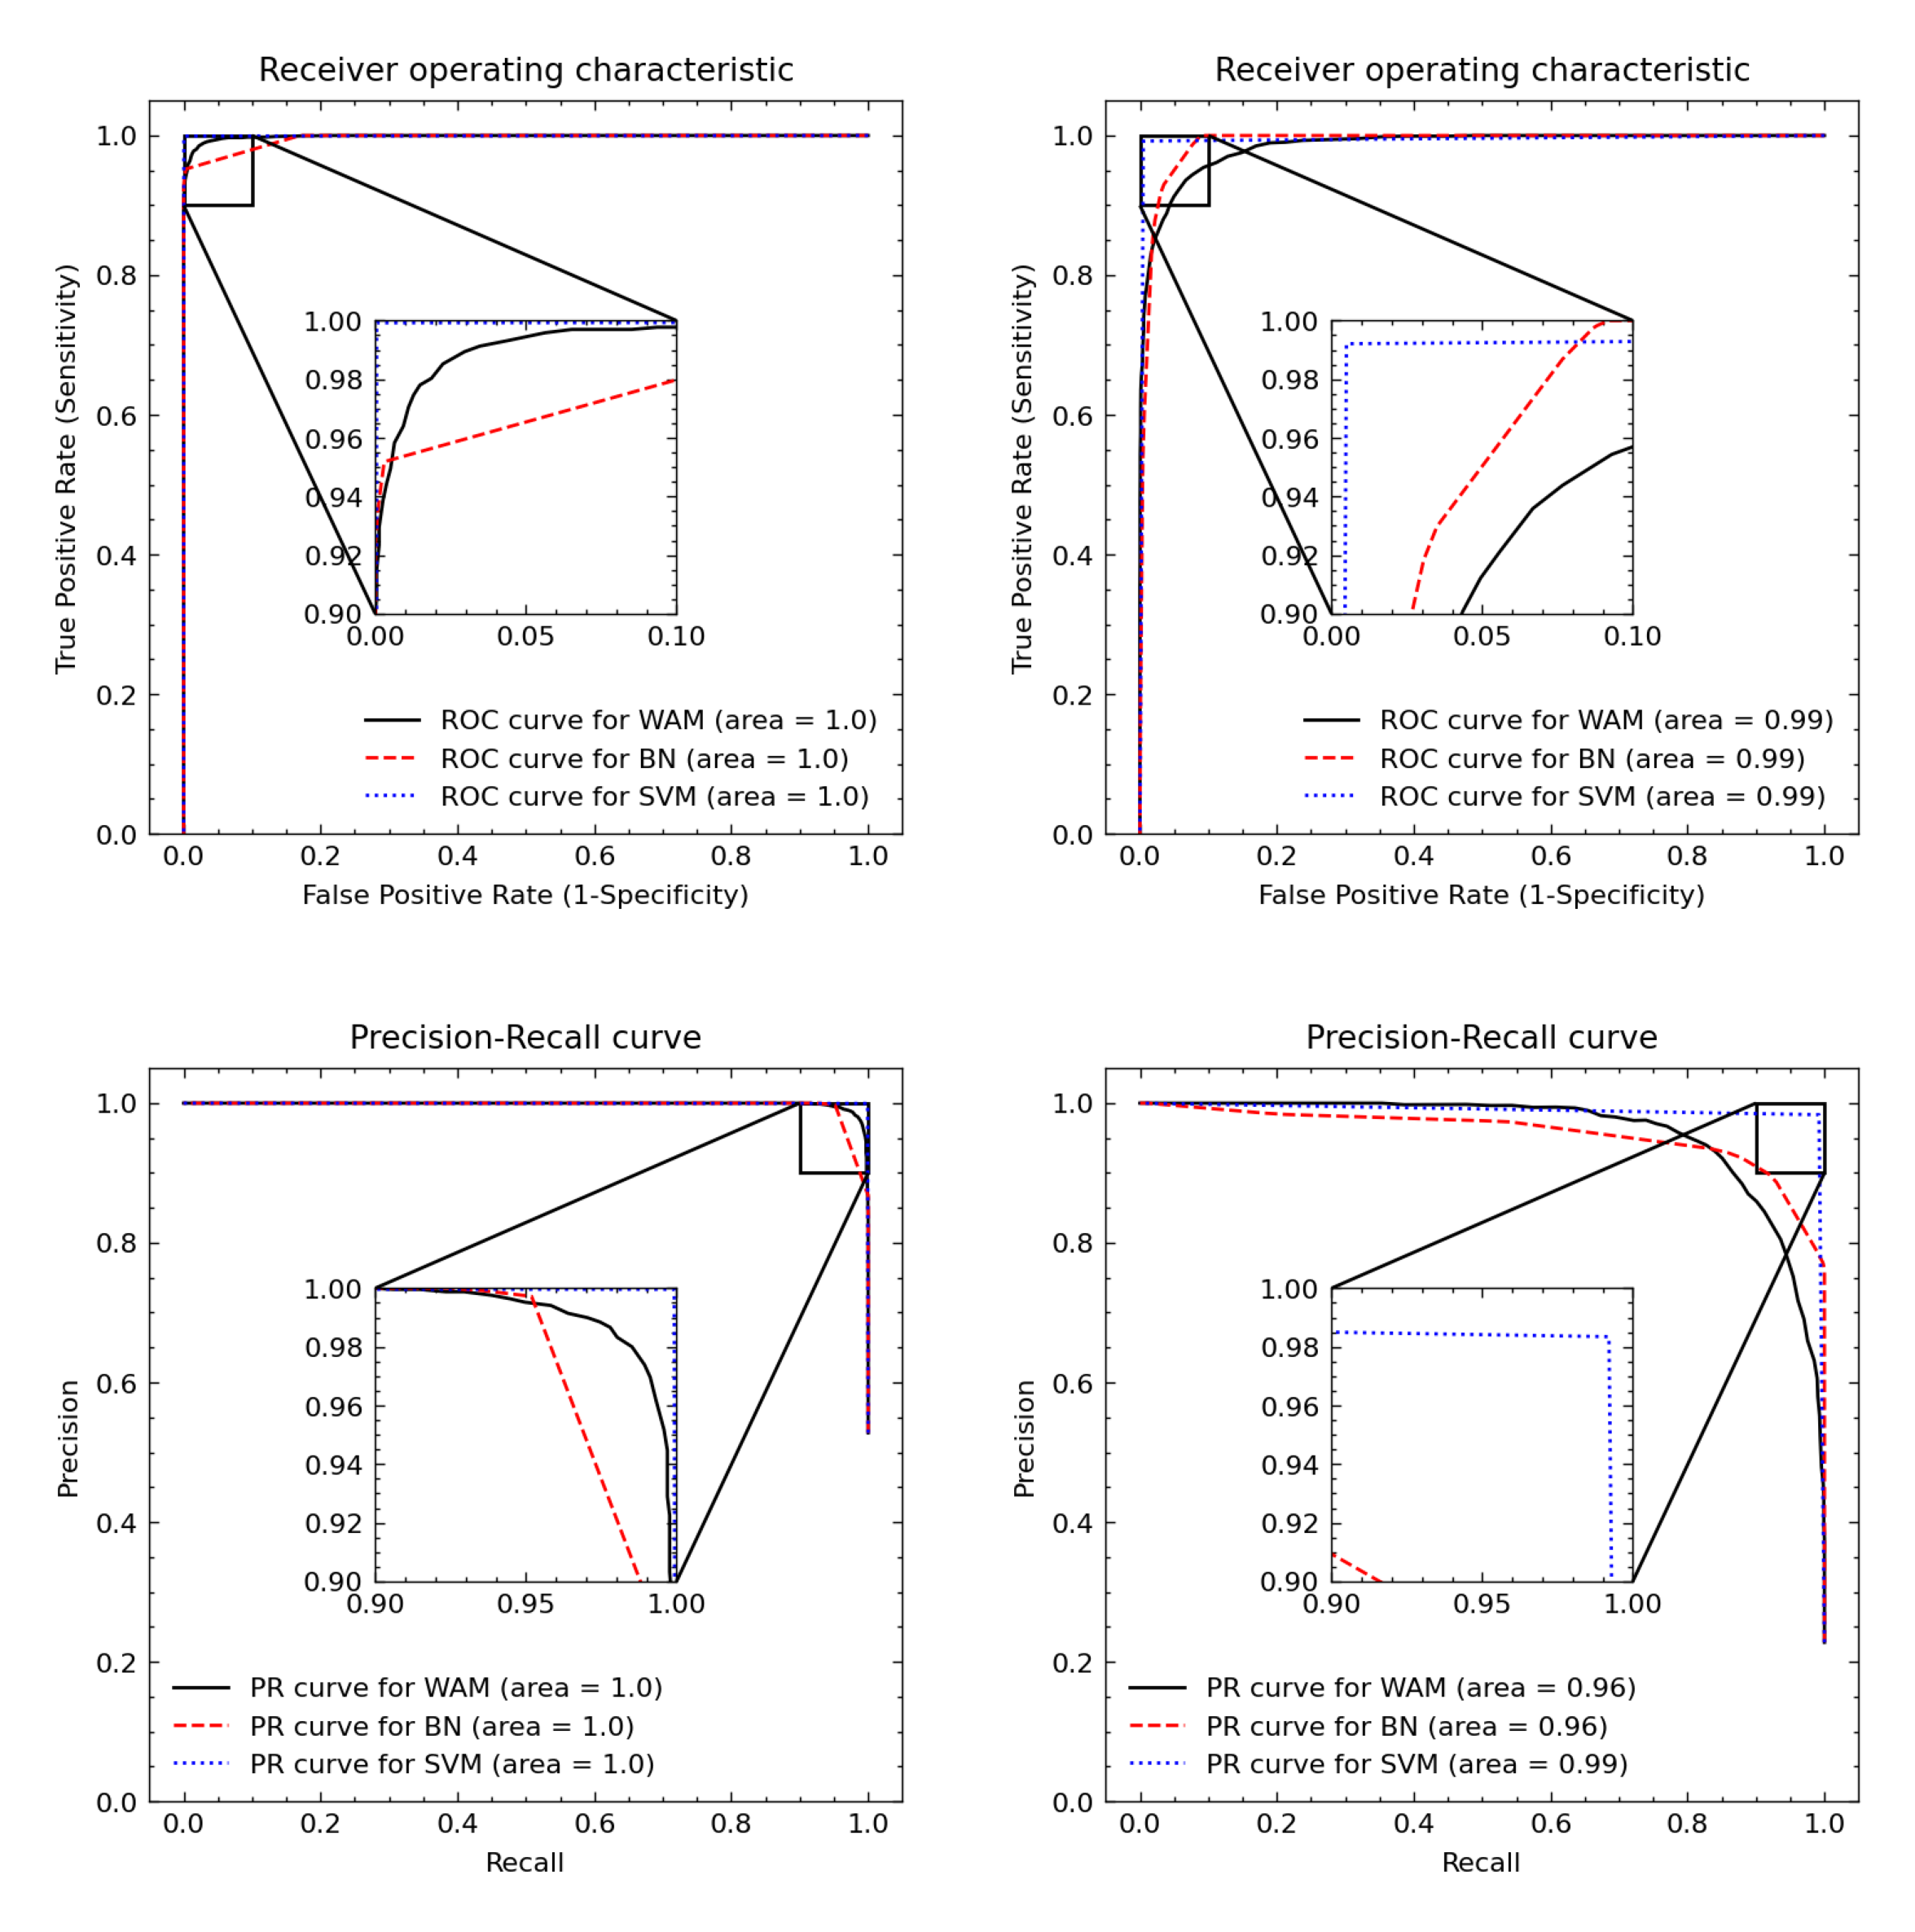

In [164]:
fs = ['../Figures/F1_t_1.png', '../Figures/ROC_1.png', '../Figures/PRC_1.png', 
      '../Figures/F1_t_2.png', '../Figures/ROC_2.png', '../Figures/PRC_2.png']
figs = [pli.imread(i) for i in fs]

plt.subplots_adjust(left=0.0,bottom=0.0,top=1.2,right=1.2)
figure, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, dpi=200, figsize=(12,12))
[no_box(ax) for ax in (ax1, ax2, ax3, ax4)]
ax1.imshow(figs[1]); ax2.imshow(figs[4]); ax3.imshow(figs[2]); ax4.imshow(figs[5])

'''ax2 = plt.subplot(2,2,2); no_box(ax2); plt.imshow(figs[2])
ax3 = plt.subplot(2,1,2); no_box(ax3); plt.imshow(figs[0])
'''
plt.tight_layout()

## Model selection

In the experiments, their performances are slightly different since their strategies of detecting splice signals are different. But obviously, there is a situation that unbalanced data affects, compare to the first experiment, their metrics in the second experiment has significantly declined, especially $auPRC$ for WAM and BN.

### Weighted Array Model

WAM shows decent accuracy in the experiments considering its low cost of computating power. It has the ability to discover low level features of splice site (Fig. 2), but higher level feature detection remains imposible. As Weighted array model calculate adjacent bases frequencies at each position, it can only detect common adjacent bases near the splice sites. In both two experiments, WAM has detected the information well (see figure 1.). The result shows that GG, GT, TA bases are more frequent near splice site. This agrees with some of the facts that have been found [28]. 

<Figure size 1980x1500 with 0 Axes>

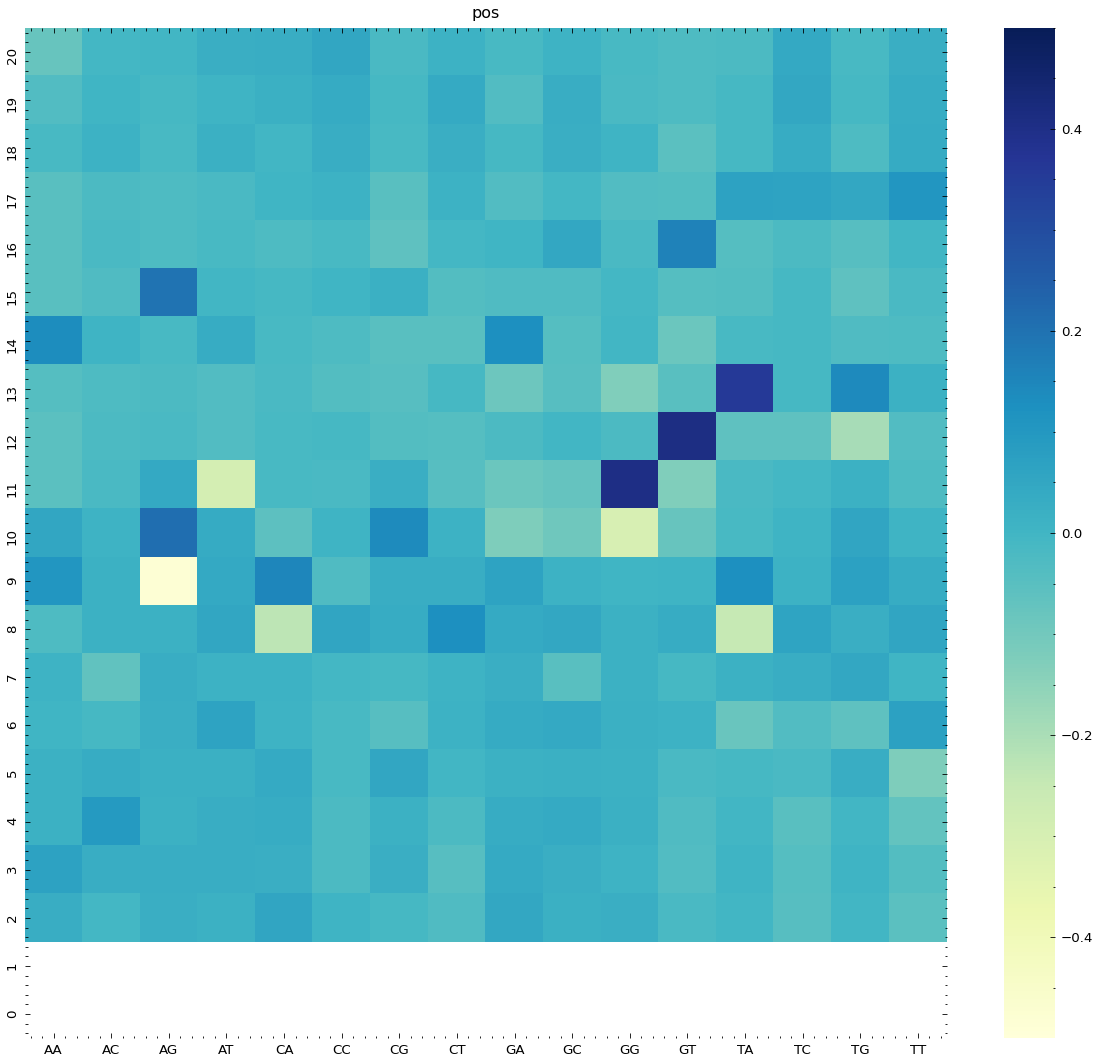

In [95]:
weights_diff = model_2.wam.positive_weights - model_2.wam.negative_weights
plt.subplots_adjust(left=0.0,bottom=0.0,top=1.2,right=1.2)
fig, ax1 = plt.subplots(1,1, figsize=(10, 9), dpi=120)
ax = sns.heatmap((model_1.wam.positive_weights - model_1.wam.negative_weights)[::-1], 
                 vmin=-0.5, vmax=0.5, ax=ax1, cmap="YlGnBu")
ax1.set_title('pos'); plt.tight_layout()

The result also shows that there is a performance decline in experiment 2 (Fig. 1). The main reason of this is that donor information contained in second training data set is much less than first data set (Fig. 1 & 3). In other words, the frequency of some adjacent bases within each position near the donor sites are lower in the unbalanced data set (Fig. 3). The model cannot learn weights, which were informatively comprehensive enough, to precisely classify donor site in that situation (Fig. 1). Thus, To build a reliable WAM model, the information contained in true splice sites and pseudo sites need to be very comprehensive.

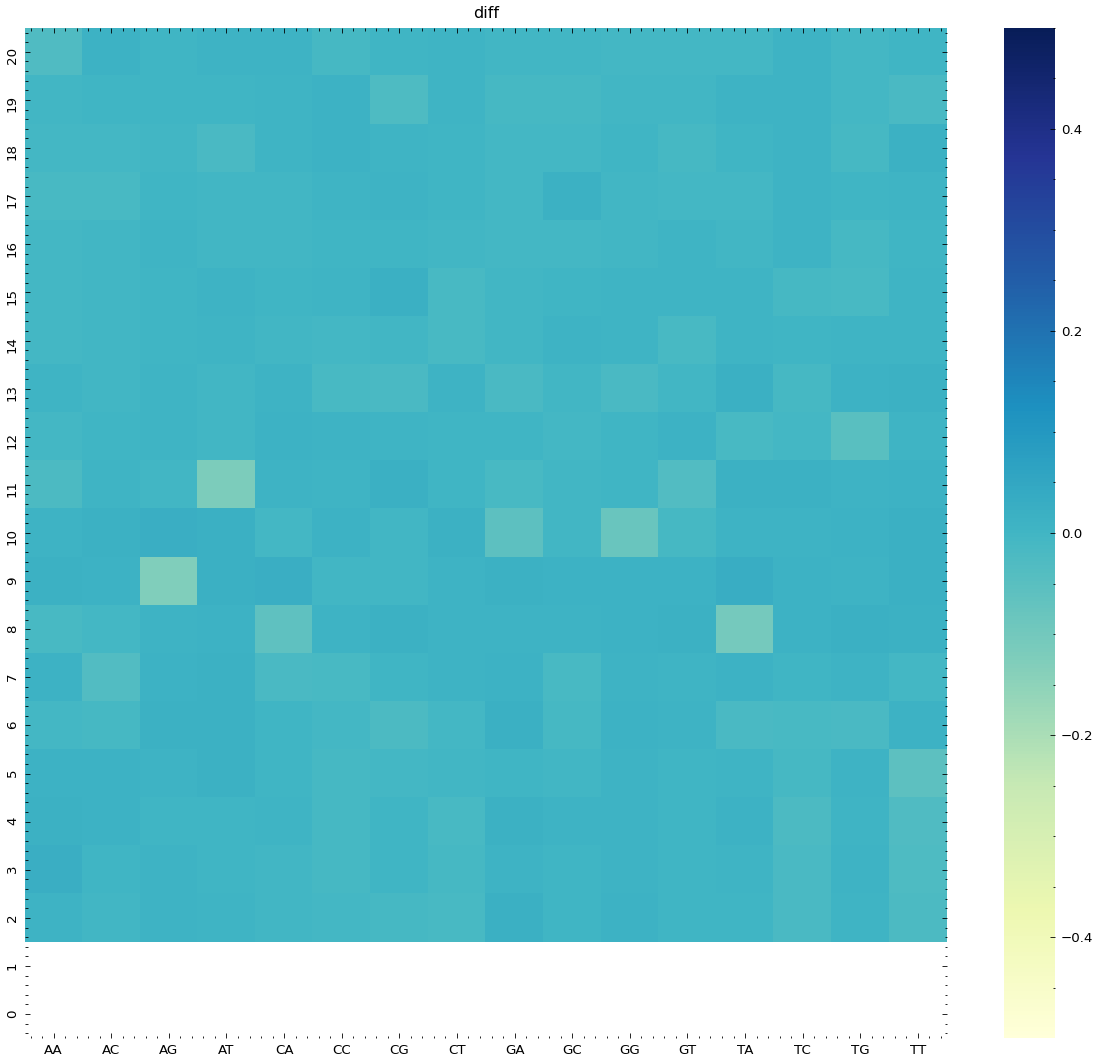

In [96]:
fig, ax2 = plt.subplots(1,1, figsize=(10, 9), dpi=120)
ax = sns.heatmap(((model_1.wam.positive_weights - model_1.wam.negative_weights) - 
                  (model_2.wam.positive_weights - model_2.wam.negative_weights))[::-1], 
                 vmin=-0.5, vmax=0.5, ax=ax2, cmap="YlGnBu")
ax2.set_title('diff'); plt.tight_layout()

### Bayesian Network

Bayesian network uses $\chi^2 -test$ [21] and conditional independent test, to build the dependency graph for each position near the splice site and also donor potential. In both two experiments, BN has detected the conditional dependence between positions and donor potential (Fig. 4). 

But there are some imperfections. First, directions of edges in the graph may learn wrong due to separated learning algorithm (Fig. 4). During structure learning, if there is an edge $N_0 \rightarrow N_{-1}$, there will not be an edge $N_0 \leftarrow N_{-1}$ because of its DAG structure. But on choromosome, it is common that adjacent positions affects each other. One way to address this limitation is to combine the structure learning and the parameter learning. When there are mutual influences, just discard edge with less influence. Or when detecting splice signals, I just wanna keep $N_{0}\leftarrow N_{-1}$ cause $N_0$ is the site. Second, BN's learning algorithm utilizes $\chi^2-test$ and conditional independent test and so more sensitive to unbalanced data (Fig. 4) [14]. So there is a significant performance decline for BN compare to SVM (Fig. 1). Furthermore, BN is susceptible to not only information contained in data set, but also distribution of data compares with WAM. This would explain the fact that performance declines in experiment 2.

Finally, classical integrated BN is in a position to detect not only dependence between positions, but also dependences between positions and donor potential, because it learns parameters from all data, donor sites and pseudo sites. While expanded Bayesian networks [22] can just detect dependence between positions, because it learns positive and negative BNs' parameters using positive and negative data respectively. 

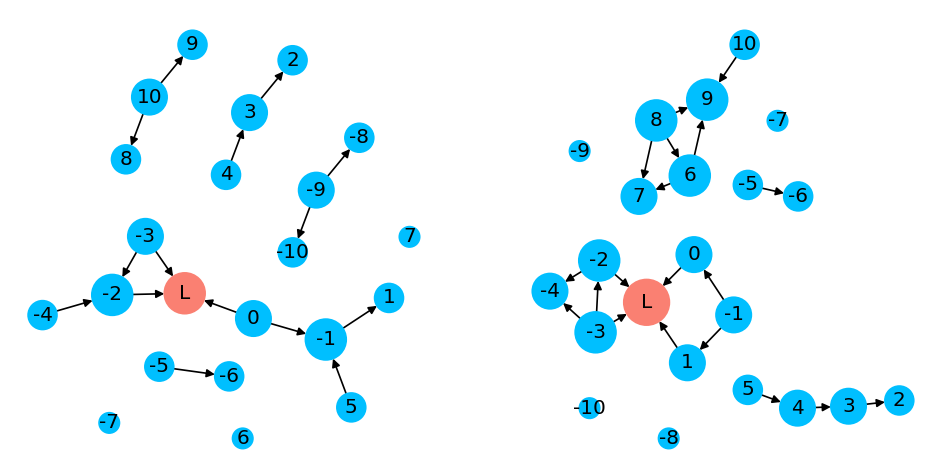

In [161]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5), dpi=120)
G1 = model_1.bn.networks
bicolors = ['deepskyblue','salmon']
nodesize = np.array([float(G1.degree(v) + 1) for v in G1])
nodecolor = np.array([bicolors[int('L' == i)] for i in G1])
nx.draw(G1, with_labels=True, textsize=10000, node_color=nodecolor,
        pos=nx.nx_agraph.graphviz_layout (G1, prog='neato'), ax=ax1,
        #pos=nx.spring_layout,
        node_size=nodesize*150)
G2 = model_2.bn.networks
bicolors = ['deepskyblue','salmon']
nodesize = np.array([float(G2.degree(v) + 1) for v in G2])
nodecolor = np.array([bicolors[int('L' == i)] for i in G2])
nx.draw(G2, with_labels=True, textsize=10000, node_color=nodecolor,
        pos=nx.nx_agraph.graphviz_layout (G2, prog='neato'), ax=ax2,
        #pos=nx.spring_layout,
        node_size=nodesize*150)

### Support Vector Machine

Support Vector machines have performed best and nearly the same in the experiments. The result shows that SVM has the potential to take care of unbalanced data. There are several benefits using SVM.

First, SVM was appropriate to provide for classification. It has the highest accuracy amoung all three models used in the experiments. The margin maximal and kernel trick gives it ability to classify very complex data. One more important feature of SVM is that only support vectors are important in order to classification. The rest can be ignored. This can easily reduce the computing power needed.

Second, when dealing with unbalanced data, the number of support vectors can be slightly the same for each class (Table S1). This makes its accuracy slightly the save as first experiment (Fig. 1). It handled the unbalanced data elegantly.

Third. There are several mature optimization algorithms with low time complexity and sophisticated software tools [11,23,25]. They were nicely implemented, make SVM's training and prediction fast. However, Visualization of the hyper-plane and high-dimensional space is impossible. Although its accuracy is excellent. It still likes a black box. We cannot know which feature are the most important or what kind of the signals were detected.

In [170]:
df = pd.DataFrame( (model_1.svm.n_support_, model_2.svm.n_support_) , columns=['Donor','Pseudo'])
df.index = ['SVM 1', 'SVM 2']
#display(HTML(df.to_html()))

## Metrics


In the experiments, we used $TPR, FPR, Sn, Sp, Rc, Pr, F1-score, auROC, auPRC$ metrics to evaluate performances of models. The result shows that $auPRC$ is more sensitive to unbalanced data than $auROC$ (Fig. 1).  

#### Simple mathamatical formulation: 
Here we note $D=Num_p(TP,FN)-Num_n(FP,TN)$ as the difference between two classes. $TPR(Num_p)$, $Sn(Num_p)$ and $Rc(Num_p)$ are independent with $Num_n$, and $FPR(Num_n), Sp(Num_n)$ are independent on $Num_p$, so they are independent with $D$. $Pr$ is the only metric that is dependent on $D$. So $auPRC=\sum_{i=1}^{N-1}\frac{(Rc_{i+1} - Rc_i)(Pr_i+Pr_{i+1})}{2}$ can enlarge the difference of performance when comparing different models on unbalanced data.

When comparing models on an unbalanced data set, we should not miss $Pr$ and $auPRC$. Besides, $F1-score=\frac{2Pr Rc}{Pr+Rc}$ also has ability to enlarge this kind of difference.

## Threshold selection

$F1-score$ [24] is another important metric. Since Pr and Rc are paradoxical sometimes, we cannot have highest $Rc$ and $Pr$ at the same time. When selection thresholds, we use $F1-score$ instead.

The result shows that all $F1-score$ reach its peak at $t\approx 0$. So $t=0$ is a suitable threshold for 3 models. For other metrics involved in threshold selection, see Table [S2.a]() and [S2.b]().

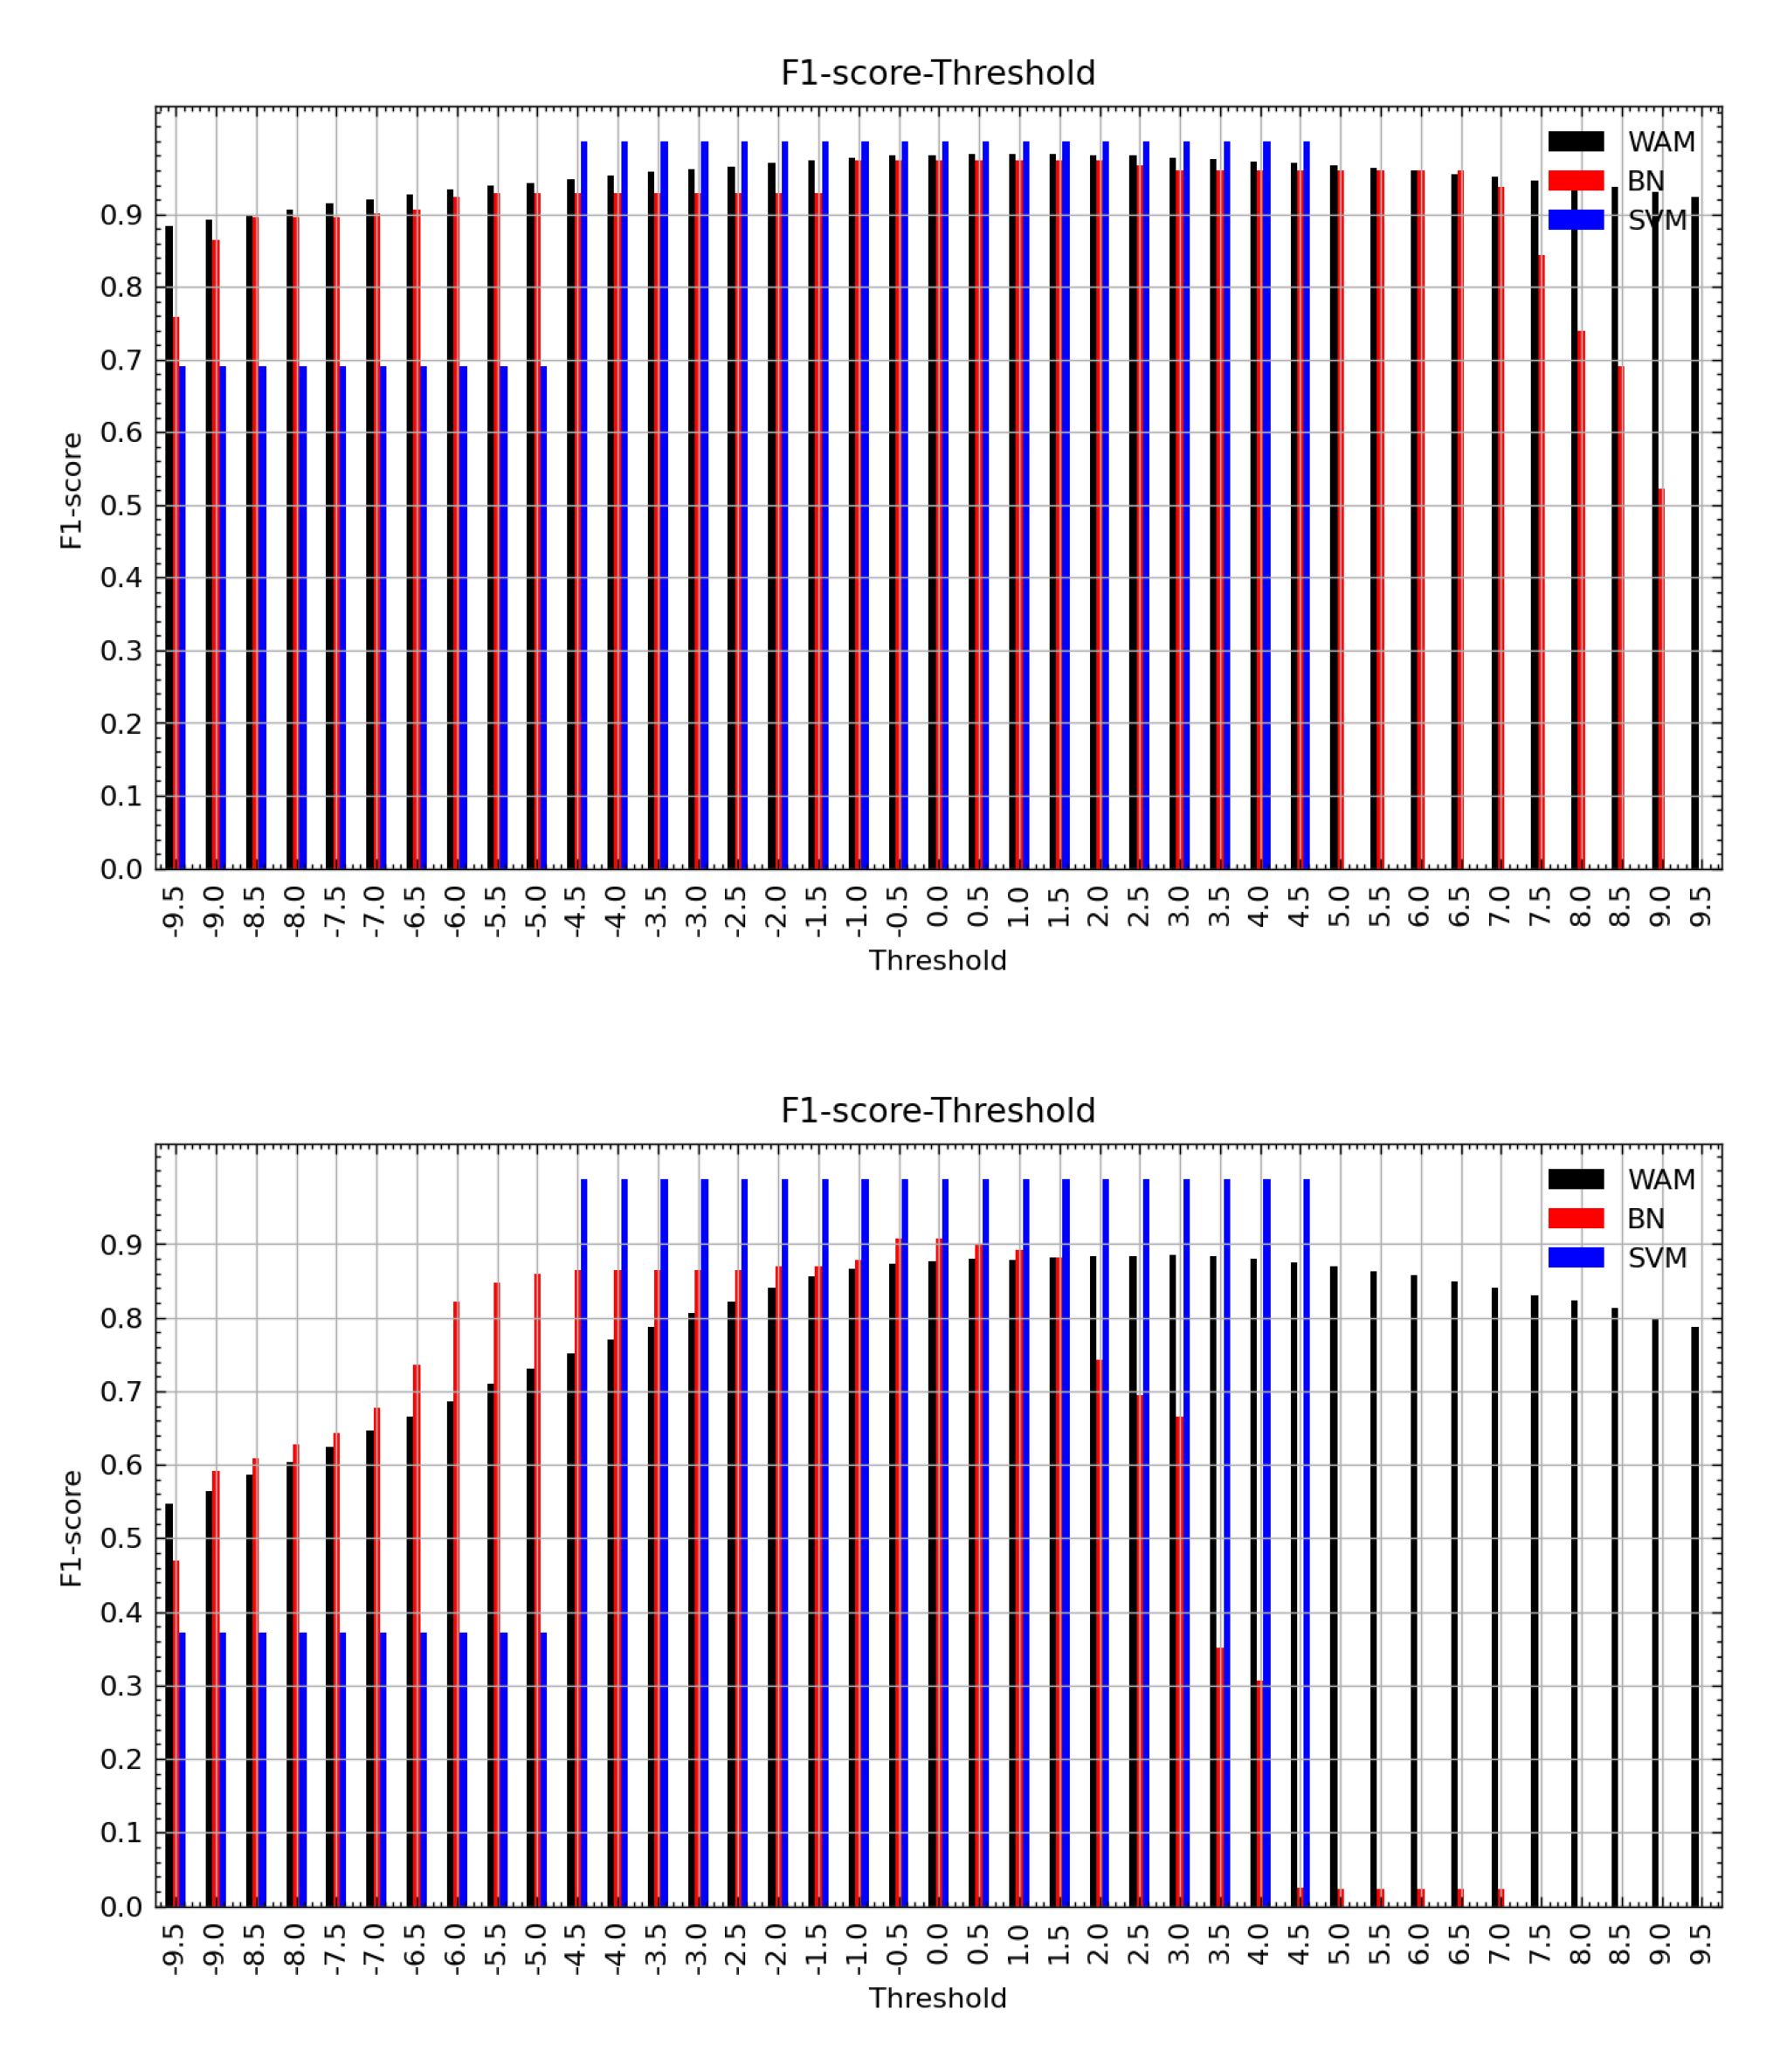

In [160]:
fs = ['../Figures/F1_t_1.png', '../Figures/F1_t_2.png']
figs = [pli.imread(i) for i in fs]

figure, (ax1, ax2) = plt.subplots(2, 1, dpi=200, figsize=(12,12))
plt.subplots_adjust(left=0.0,bottom=0.0,top=1,right=1); 
no_box(ax1); ax1.imshow(figs[0])
no_box(ax2); ax2.imshow(figs[1])
plt.tight_layout()

In [17]:
import pickle

d = {'m1': model_1, 'm2': model_2, 'e1': evaltr_1, 'e2':evaltr_2}
with open('../models/models_eval.pkl', 'wb') as f:
    pickle.dump(d, f)

In [7]:
import pickle

with open('../models/models_eval.pkl', 'rb') as f:
    d = pickle.load(f)
    
model_1 = d['m1']
model_2 = d['m2']
evaltr_1 = d['e1']
evaltr_2 = d['e2']

# Conclusion and Prospect

Some facts have been found after these attempts. First, **WAM** is good at detecting dependence between adjacent positions and costs lowest computing power. Second, **Bayesian network** still suffers from learning algorithm. PC-Contraint based algorithm and MMHC algorithm still not perfect and are so time consuming. It takes me 10 hours to train a Bayesian network. Third, **SVM** is very accurate and fast when dealing with small data set. Finally, when data set is unbalanced, A very wise choice would be selecting not only $auROC$ but also $auPRC$ as metrics to evaluate models. Or make data set balanced before training, some methods have been proposed to complete this.

The Pros and Cons of models are arranged below.

|Model|Pros|Cons|
|:----|:---|:---|
|**WAM**|Low cost of computing power, Splice signal detection, Easy to visualize|Accuracy not perfect|
|**BN**|Easy to visualize, Causual relationship inference, Splice signal detection|Immature learning algorithms, accuracy still not perfect|
|**SVM**|Extreamely high accuracy, Fast and mature learning algotithm [23,25]|Cannot visualize, Black box|

## Limitations and Prospect

There are still some limitations about this work. First, the information contained in datasets are different, this may cause a little accuracy decline. Second, the data set used in the experiments are still too small, only 5000 samples are used to training models. 

Corresponding with limitations, there are two experiments need to be done in the future. First, make information-equal data sets to repeat the experiments. Second, experiments on larger data sets need to be done as the proportion of donor sites is near $10^-3$ or even smaller.

# Availability

Data set was provided by Prof. Zhou of Huazhong University of Science and Technology. 
Source code of this project are hosted on [Github](https://github.com/AdeBC/GSSR). Besides, to encourage others to reproduce this project, all source code involved in this report was remained. Anyone can configure dependence environment can easily reproduce it.

Making research projects more reproducible are highly recommended here.

# Acknowledgements

First of all, I would like to extend my sincere gratitude to Professor Yanhong Zhou, for his valuable knowledge and experience in bioinformatic data mining that I've gained. I am deeply grateful of his patient teaching during the COVID-19 epidemic.

Second, I am also deeply indebted to all the other researchers and geeks in Bioinformatics and Data Mining for their great works and wonderful programming experiences and skills shared on the web. I cannot finish this project without them.

Finally, Special thanks should go to my parents, girlfriend and also other friends, for their continuous support and encouragement.

# References

1. M.O. Zhang, T.G. Marr, A weight array method for splicing signal analysis, Bioinformatics, Volume 9, Issue 5, October 1993, Pages 499–509, https://doi.org/10.1093/bioinformatics/9.5.499
2. Sinha, R., Hiller, M., Pudimat, R. et al. Improved identification of conserved cassette exons using Bayesian networks. BMC Bioinformatics 9, 477 (2008). https://doi.org/10.1186/1471-2105-9-477
3. Pearl J. Bayesian netwcrks: A model cf self-activated memory for evidential reasoning[C]//Proceedings of the 7th Conference of the Cognitive Science Society, University of California, Irvine, CA, USA. 1985: 15-17.
4. Sonnenburg, S., Schweikert, G., Philips, P. et al. Accurate splice site prediction using support vector machines. BMC Bioinformatics 8, S7 (2007). https://doi.org/10.1186/1471-2105-8-S10-S7
5. Cortes, C., Vapnik, V. Support-vector networks. Mach Learn 20, 273–297 (1995). https://doi.org/10.1007/BF00994018
6. Boyd K, Eng K H, Page C D. Area under the precision-recall curve: point estimates and confidence intervals[C]//Joint European conference on machine learning and knowledge discovery in databases. Springer, Berlin, Heidelberg, 2013: 451-466.
7. Gilbert W. Why genes in pieces?. *Nature*. 1978;271(5645):501. doi:10.1038/271501a0
8. deeplizard. One-hot Encoding explained. YouTube. 2018-01-12 [2019-09-08]
9. Nomenclature for Incompletely Specified Bases in Nucleic Acid Sequences, NC-IUB, 1984.
10. Oliphant T E. Python for scientific computing[J]. Computing in Science & Engineering, 2007, 9(3): 10-20.
11. Pedregosa F, Varoquaux G, Gramfort A, et al. Scikit-learn: Machine learning in Python[J]. the Journal of machine Learning research, 2011, 12: 2825-2830.
12. Ankan A, Panda A. pgmpy: Probabilistic graphical models using python[C]//Proceedings of the 14th Python in Science Conference (SCIPY 2015). 2015.
13. C.D. Manning, P. Raghavan and M. Schütze (2008). *Introduction to Information Retrieval*. Cambridge University Press, p. 260.
14. P. Spirtes, C. Glymour, and R. Scheines. Causation, prediction, and search. Springer-Verlag, New York, 1993.
15. Vert J P, Tsuda K, Schölkopf B. A primer on kernel methods[J]. Kernel methods in computational biology, 2004, 47: 35-70.
16. Stone M. Cross‐validatory choice and assessment of statistical predictions[J]. Journal of the Royal Statistical Society: Series B (Methodological), 1974, 36(2): 111-133.
17. Fawcett, Tom (2006); *An introduction to ROC analysis*, Pattern Recognition Letters, 27, 861–874.
18. Boyd K, Eng K H, Page C D. Area under the precision-recall curve: point estimates and confidence intervals[C]//Joint European conference on machine learning and knowledge discovery in databases. Springer, Berlin, Heidelberg, 2013: 451-466.
19. Hanley JA, McNeil BJ. A method of comparing the areas under receiver operating characteristic curves derived from the same cases. *Radiology*. 1983;148(3):839-843. doi:10.1148/radiology.148.3.6878708
20. Ossendrijver M. Ancient Babylonian astronomers calculated Jupiter's position from the area under a time-velocity graph. *Science*. 2016;351(6272):482-484. doi:10.1126/science.aad8085
21. McHugh M L. The chi-square test of independence[J]. Biochemia medica: Biochemia medica, 2013, 23(2): 143-149.
22. Chen T M, Lu C C, Li W H. Prediction of splice sites with dependency graphs and their expanded Bayesian networks[J]. Bioinformatics, 2005, 21(4): 471-482.
23. Platt J. Sequential minimal optimization: A fast algorithm for training support vector machines[J]. 1998.
24. Sasaki, Yutaka. (2007). The truth of the F-measure. Teach Tutor Mater. 
25. Chang C C, Lin C J. LIBSVM: A library for support vector machines[J]. ACM transactions on intelligent systems and technology (TIST), 2011, 2(3): 1-27.